# SOLA METHOD WITHOUT NOISE
We address the task of estimating a finite‐dimensional property of an unknown model from noiseless observations.  Let
$$
m \in \mathcal{M},
\quad
\tilde{\mathbf{d}} \in \mathcal{D} \cong \mathbb{R}^{N_d},
\quad
\tilde{\mathbf{p}} \in \mathcal{P} \cong \mathbb{R}^{N_p},
$$
where $\mathcal{M}$ is a separable Hilbert space, and $\mathcal{D},\mathcal{P}$ are Euclidean spaces of dimensions $N_d$ and $N_p$.


The forward map is a bounded linear operator
$$
G:\mathcal{M}\to \mathcal{D},
\qquad
[G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
and the data are modeled by
$$
\mathbf{d} = G(m)
$$
$K_i \in \mathcal{M}$ are sensitivity kernels. Similarly, the property of interest is extracted via
$$
\mathcal T:\mathcal{M}\to \mathcal{P},
\qquad
[\mathcal T(m)]_k = \langle T^{(k)}, m \rangle_{\mathcal{M}}
$$
where $T^{(k)}$ are the target kernels. Our ultimate goal is to recover
$$
\bar{\mathbf{p}} = \mathcal T(\bar m),
$$
where $\bar m$ is the (unknown) true model.  Since the inverse problem is ill‐posed, we do not attempt to reconstruct $\bar m$ directly.  Instead, we seek a surrogate operator
$$
\mathbf{X}:\mathcal{D} \to \mathcal{P}
$$
that approximates the composition $\mathcal T \circ G^{-1}$ on the most probable model(s).  In practice, we will apply $\mathbf{X}$ to the MAP estimate in data space (basically, the observed data $\mathbf{\tilde{d}}$).

To ensure $\mathbf{X}$ faithfully reproduces our desired property, we enforce
$$
\mathcal T \approx \mathbf{X}\,G,
$$
and measure the discrepancy in the Hilbert–Schmidt norm. Therefore, we seek $X$ as the solution to the following optimization problem:
$$
\min_{\mathbf{X}}\;\|\mathcal T - \mathbf{X}G\|_{HS}^2,
\quad
\|A\|_{HS}^2 = Tr \bigl(A\,A^*\bigr).
$$

The solution is:
$$
X = \mathcal{T} G^*(GG^*)^{-1}
$$

From this we can obtain the approximate property
$$
    \mathbf{\tilde{p}} = X(\mathbf{\tilde{d}})
$$
Since we do not work with noise or any other kind of uncertainties, this is our final answer. It can be shown that it corresponds to the property of the least norm solution, in other words
$$
    \mathbf{\tilde{p}} = X(\mathbf{\tilde{d}}) = \mathcal{T}(\tilde{m})
$$

Now we will show how to solve this problem using pygeoinf.

First we need to import all the required modules

In [2]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.operators import LinearOperator
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.functions import Function
from pygeoinf.linear_solvers import CholeskySolver
import matplotlib.pyplot as plt
import numpy as np

Then we create an domain for the functions that represent models. Using this domain, we build the model space as an L2Space. We also build the data and property spaces as euclidean spaces.

In [3]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain) # model space
N_d = 45 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

Then we create a set of sensitivity kernels for the forward map, and target kernels for the property map.

In [4]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=1000)

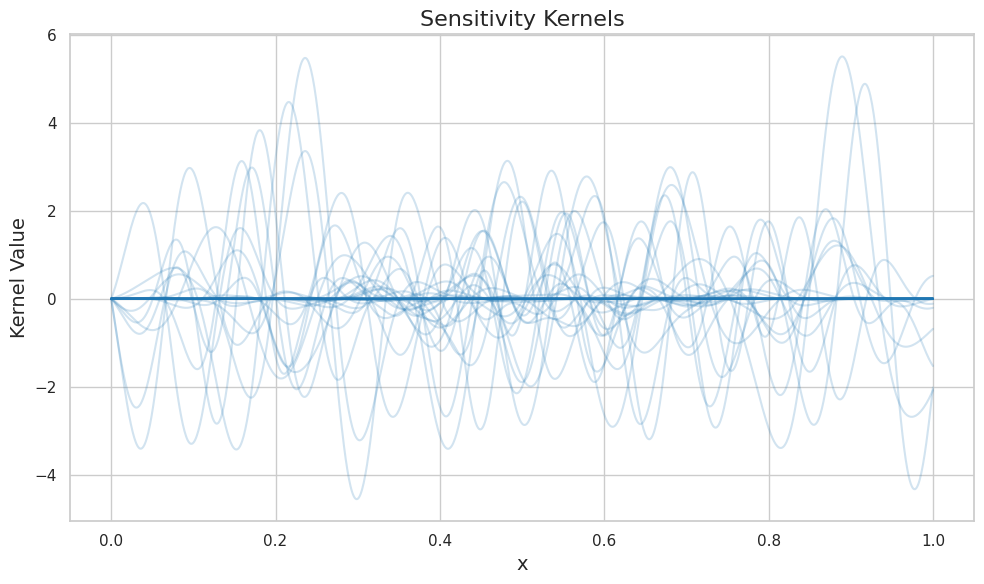

In [5]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.2)
plt.title('Sensitivity Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

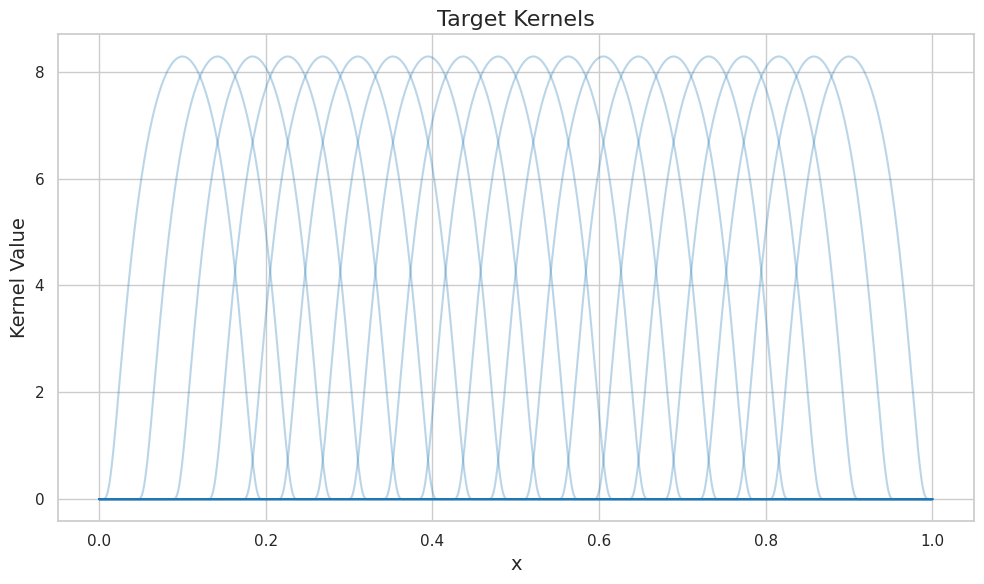

In [6]:
plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, T.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Target Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

We create a true model $\bar{m}$ and the coresponding data $\mathbf{\bar{d}}$.

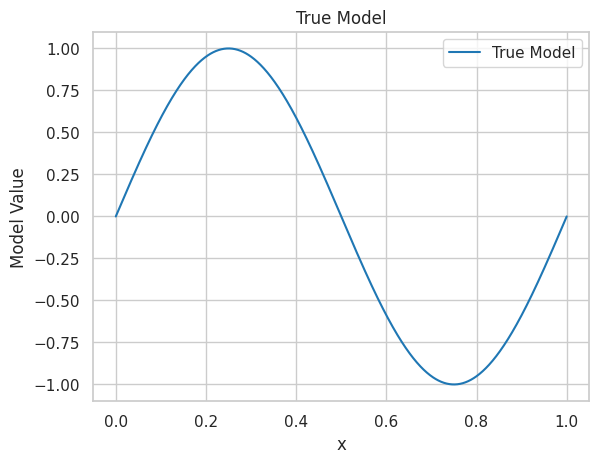

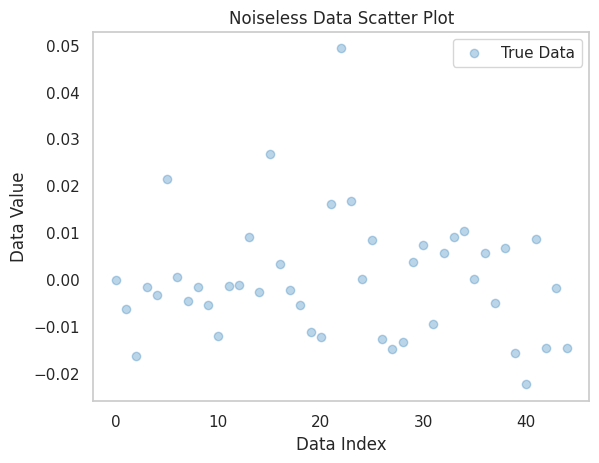

In [7]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Plot the true model
plt.plot(x, m_bar.evaluate(x), label='True Model', color='tab:blue')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.show()

# Create corresponding data
d_bar = G(m_bar)

plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', color='tab:blue', alpha=0.3)
plt.xlabel('Data Index')
plt.ylabel('Data Value')
plt.grid()
plt.title('Noiseless Data Scatter Plot')
plt.legend()
plt.show()

Now we compute the the solution operator $\mathbf X$ as well as the least norm pseudo-inverse.

In [8]:
# Compute normal operator
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())
cholesky_solver = CholeskySolver(galerkin=True)
Lambda_inv = cholesky_solver(Lambda)
G_inv = G.adjoint @ Lambda_inv
X = T @ G_inv

Altough we are not searching for a model since we are doing an inference, we can still find the model to which the inference corresponds (the least norm solution) and we can plot it.

In [9]:
# Compute both the solution from the true data
m_tilde = G_inv(d_bar)

And we can compare it with the true solution. With sufficient data, the least norm solution will converge to the true solution.

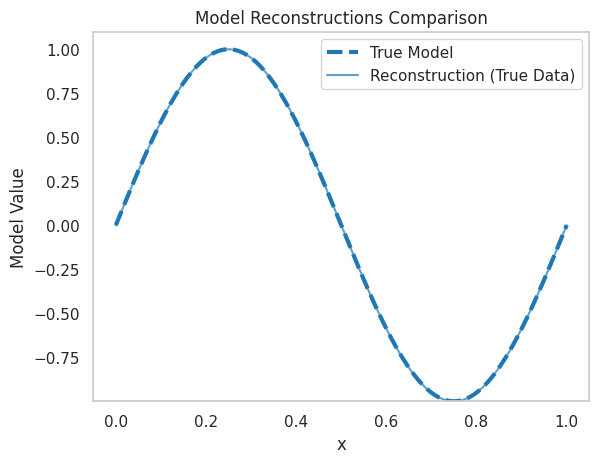

In [10]:
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--', color='tab:blue', linewidth=3)
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (True Data)', color='tab:blue', alpha=0.7, linewidth=1.5)
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()

Now we can finally compute the inference solution $\mathbf{\tilde{p}}$ and compare it with the true property $\mathbf{\bar{p}}$.

In [11]:
# Compute the property values for the true model and the reconstructions
p_bar = T(m_bar)
p_tilde = T(m_tilde)

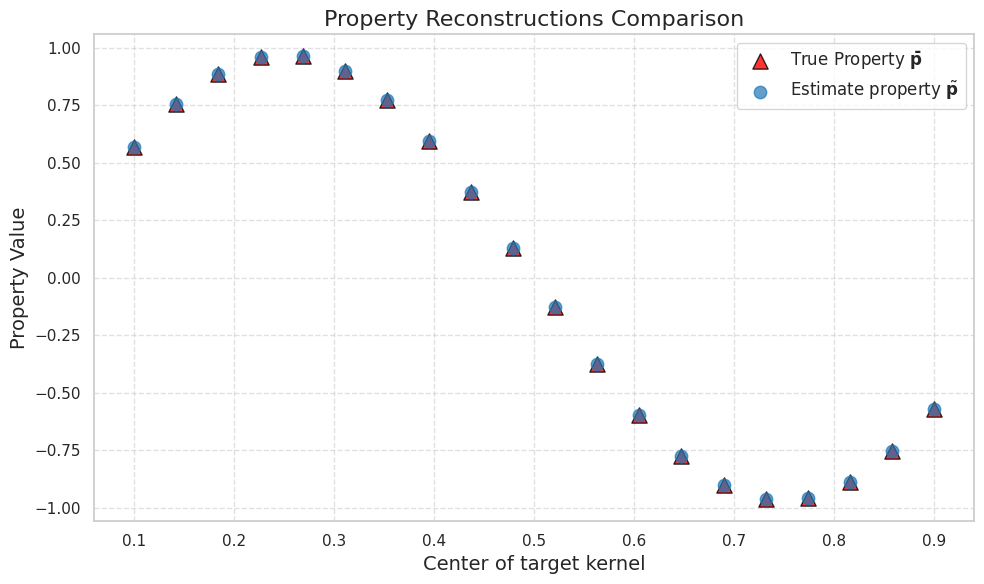

In [12]:
# Improved property reconstructions comparison figure
plt.figure(figsize=(10, 6))
plt.scatter(centers, p_bar, label=r'True Property $\mathbf{\bar{p}}$', color='red', marker='^', s=120, edgecolor='black', alpha=0.8)
plt.scatter(centers, p_tilde, label=r'Estimate property $\mathbf{\tilde{p}}$', color='tab:blue', marker='o', s=80, alpha=0.7)
plt.ylim(np.max(p_bar) * -1.1, np.max(p_bar) * 1.1)
plt.title('Property Reconstructions Comparison', fontsize=16)
plt.xlabel('Center of target kernel', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True)
plt.tight_layout()
plt.show()

## Resolving Kernels

This solution can be interpreted in two distinct but ultimately equivalent ways:

1. As the **true property of the least-norm solution**,
   $$
   \mathcal{T}(\tilde{m}),
   $$
   where $\tilde{m}$ is the minimum-norm solution to the inverse problem.

2. As an **approximate mapping of the true model**,
   $$
   \mathcal{A}(\bar{m}),
   $$
   where $\bar{m}$ is the true model, and $\mathcal{A}$ approximates the true property operator $\mathcal{T}$.

We define the approximate mapping $\mathcal{A}$ as
$$
\mathcal{A} = XG,
$$
where $G$ is the forward operator and $X$ maps data to the property space. But why are these two interpretations equivalent?

To understand this, consider the set of all models that are consistent with the observed data $\bar{\mathbf{d}}$:
$$
S = G^{-1}(\bar{\mathbf{d}}),
$$
where $S$ is the **data preimage** under $G$. This set includes both the true model $\bar{m}$ and the least-norm solution $\tilde{m}$. Since we cannot directly access the true property $\mathcal{T}(\bar{m})$, we adopt an alternative strategy: define an approximate operator $\mathcal{A}$ that behaves like $\mathcal{T}$ **within the solution set** $S$.

The key idea is to construct $\mathcal{A}$ such that, for any model $m \in S$, the mapping $\mathcal{A}(m)$ yields the same value in the property space:
$$
\mathcal{A}(m) = \text{constant}, \quad \forall m \in S.
$$
Because $\bar{m} \in S$, this implies
$$
\mathcal{A}(\bar{m}) = \mathcal{A}(\tilde{m}) = \mathcal{T}(\tilde{m}).
$$
Thus, although we cannot compute $\mathcal{T}(\bar{m})$ directly, we have nonetheless recovered a meaningful approximation of it through $\mathcal{A}(\bar{m})$.

This motivates defining $\mathcal{A}$ as the composition:
$$
\mathcal{A} = \mathbf X G,
$$
because $G(m) = \bar{\mathbf{d}}$ for all $m \in S$, and $\mathbf X$ then maps $\bar{\mathbf{d}}$ to the property space. The resulting operator $\mathcal{A}$ is not the exact property of the true model, but under this philosophy, it is still informative—it tells us something consistent about the true model based on the data.

Importantly, this reinterpretation leads to the same optimization problem used to determine $\mathbf X$. The difference lies only in the **interpretation** of the result: instead of viewing the output as $\mathcal{T}(\tilde{m})$, we now interpret it as an approximation $\mathcal{A}(\bar{m})$ of $\mathcal{T}(\bar{m})$.

Just as the operator $\mathcal{T}$ is characterized by **target kernels**, the approximate operator $\mathcal{A}$ is associated with its own **resolving kernels**, defined as:
$$
A^{(k)} = \sum_i X_{ki} K_i,
$$
where $\{K_i\}$ are basis functions in the model space. These resolving kernels describe how the data constrain the recovery of each property component.


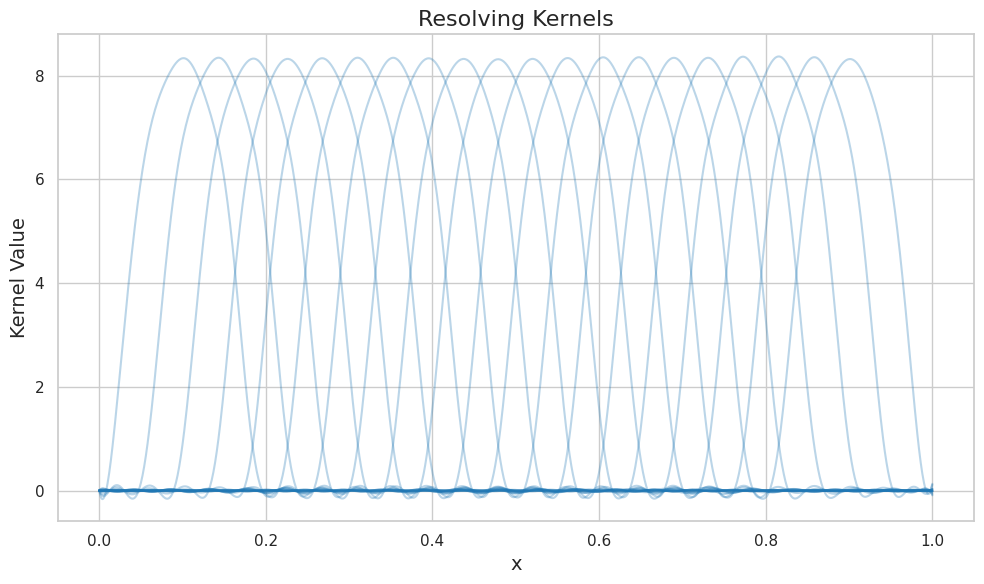

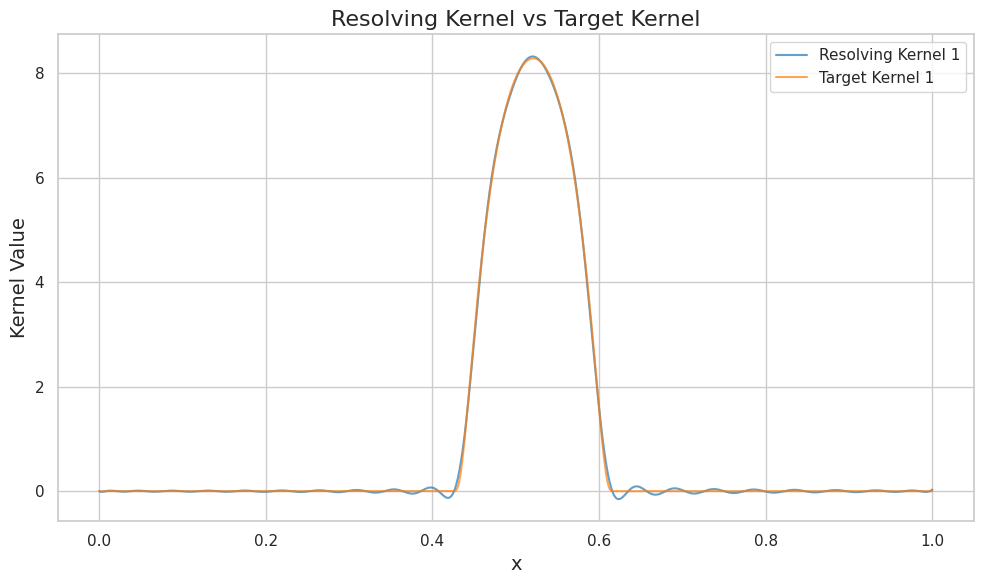

In [13]:
# Compute approximate mapping
A = X @ G

plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, A.adjoint(P.basis_vector(i)).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Resolving Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, A.adjoint(P.basis_vector(N_p//2)).evaluate(x), label='Resolving Kernel 1', color='tab:blue', alpha=0.7)
plt.plot(x, T.function_provider.get_function_by_index(N_p//2).evaluate(x), label='Target Kernel 1', color='tab:orange', alpha=0.7)
plt.title('Resolving Kernel vs Target Kernel', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Imposing Unimodularity

The classic SOLA method interprets results through the **resolving kernels**. A key advantage of this approach is that it provides information about the true model **without relying on any prior assumptions** imposed on the model space (besides the choice of the model space itself).

However, a notable drawback is that the resolving kernels are generally **not identical** to the **target kernels**. This difference makes their interpretation more difficult. For example, if the target kernels are intended to act as **averaging kernels**—extracting a local average of the model—then they are typically **unimodular**, meaning their integral is equal to one. In contrast, the resolving kernels may **not be unimodular**, which leads to two problems:

1. They may not represent the same type of average we initially intended.
2. Worse, they may introduce a **bias**, producing an average that is systematically distorted.

To address this, we can impose an additional constraint that forces the resolving kernels to be unimodular:
$$
\int A^{(k)} = 1.
$$
This condition ensures that each resolving kernel integrates to one, thereby preserving the interpretation of an unbiased average.

It can be shown that this integral constraint is **equivalent** to the linear constraint:
$$
X \mathbf{v} = \mathbf{w},
$$
where:
- $\mathbf{v} = G(1)$ is the data predicted by a constant model equal to one (i.e., the forward model applied to the constant function),
- $\mathbf{w} = (1, 1, \ldots, 1)$ is a vector in the data space $\mathcal{D}$ representing a uniform unit response.

The modified optimization problem becomes:
$$
\min_{\mathbf{X}} \; \| \mathcal T - \mathbf{X}G \|_{HS}^2, \quad
\text{subject to} \quad X \mathbf{v} = \mathbf{w},
$$
where $\|\cdot\|_{HS}$ denotes the Hilbert–Schmidt norm.

The solution to this constrained minimization is given by:
$$
\mathbf X = \mathbf X_0 - \frac{X_0 \mathbf{v} - \mathbf{w}}{\beta} \mathbf{u}^{\top},
$$
where:
- $\mathbf X_0$ is the solution to the **unconstrained** problem,
- $\mathbf{u} = (GG^*)^{-1} \mathbf{v}$,
- $\beta = \mathbf{v}^{\top} \mathbf{u}$.

This correction ensures that the resolving kernels are properly normalized, aligning them more closely with the intended target kernels.


In [14]:
# Imposing unimodularity
M_one = Function(M, evaluate_callable=lambda x: np.ones_like(x))
v = G(M_one)
w = np.ones(N_p)
u = Lambda_inv(v)
beta = D.inner_product(v, u)
correction = LinearOperator.from_matrix(D, P, np.outer((X(v) - w) / beta, u))
X_unimodular = X - correction

In [15]:
# Finding the unimodular property
p_hat = X_unimodular(d_bar)

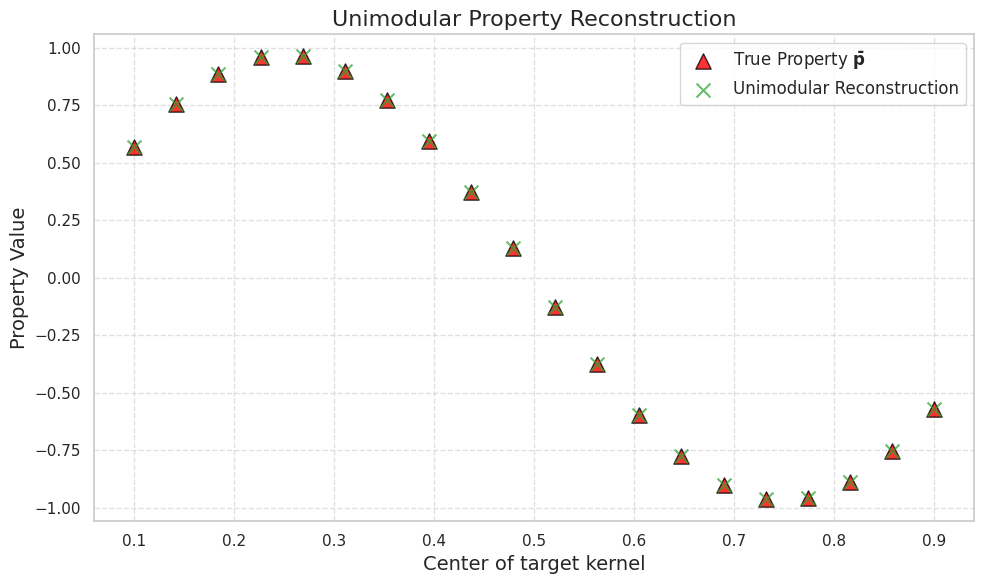

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(centers, p_bar, label=r'True Property $\mathbf{\bar{p}}$', color='red', marker='^', s=120, edgecolor='black', alpha=0.8)
plt.scatter(centers, p_hat, label='Unimodular Reconstruction', color='tab:green', marker='x', s=100, alpha=0.7)
plt.ylim(np.max(p_bar) * -1.1, np.max(p_bar) * 1.1)
plt.title('Unimodular Property Reconstruction', fontsize=16)
plt.xlabel('Center of target kernel', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True)
plt.tight_layout()
plt.show()

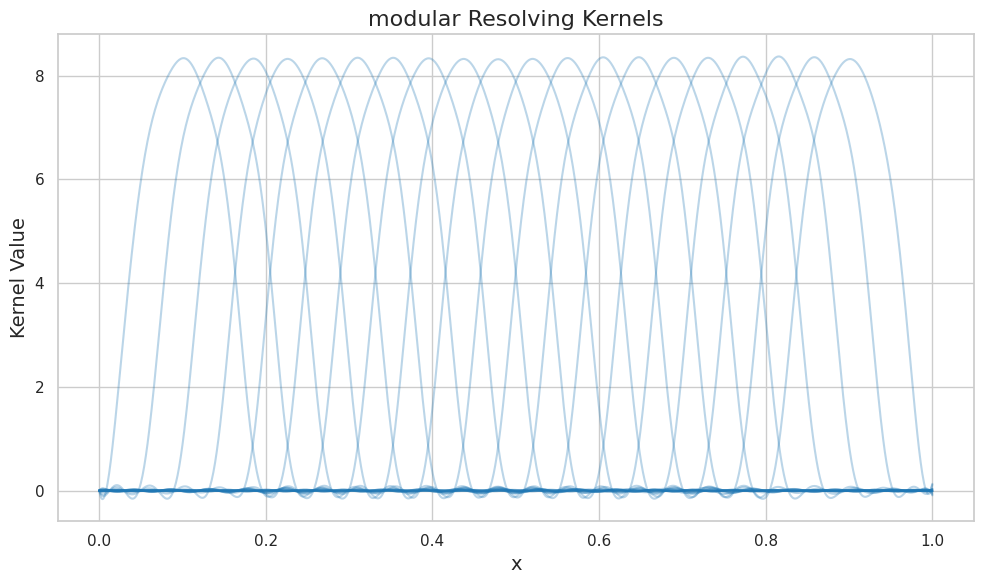

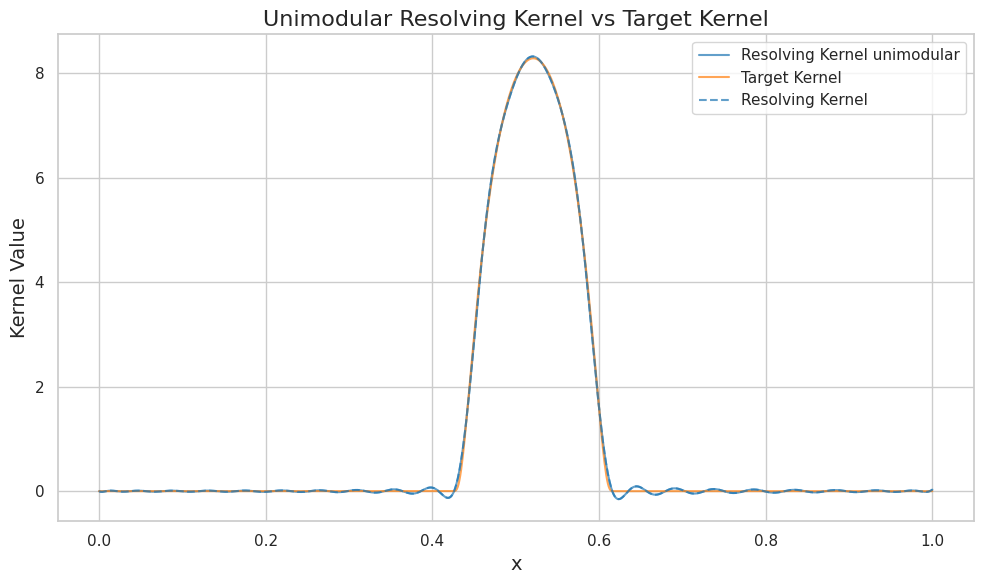

In [17]:
# Compute approximate mapping
A_unimodular = X_unimodular @ G

plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, A_unimodular.adjoint(P.basis_vector(i)).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('modular Resolving Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, A_unimodular.adjoint(P.basis_vector(N_p//2)).evaluate(x), label='Resolving Kernel unimodular', color='tab:blue', alpha=0.7)
plt.plot(x, T.function_provider.get_function_by_index(N_p//2).evaluate(x), label='Target Kernel', color='tab:orange', alpha=0.7)
plt.plot(x, A.adjoint(P.basis_vector(N_p//2)).evaluate(x), label='Resolving Kernel', color='tab:blue', alpha=0.7, linestyle='--')
plt.title('Unimodular Resolving Kernel vs Target Kernel', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print(T(M_one))
print(A(M_one))
print(A_unimodular(M_one))  # Display the unimodular property values at the centers

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99948984 0.99959083 0.99971734 0.99988304 1.00005473 1.0001526
 1.00015594 1.00010314 1.00004164 0.99999594 0.99997042 0.99996089
 0.99996305 0.99997575 0.99999588 1.00001083 1.00000451 0.99998559
 0.9999897  0.99999921]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
